# Try segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
folder = 'labels'
path = Path('data/fireandsmoke')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

folder = 'images'
path = Path('data/fireandsmoke')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('data/fireandsmoke/labels'),
 PosixPath('data/fireandsmoke/images'),
 PosixPath('data/fireandsmoke/pic1.jfif'),
 PosixPath('data/fireandsmoke/video1.mp4'),
 PosixPath('data/fireandsmoke/.ipynb_checkpoints')]

In [4]:
path_img = path/'images'
path_lbl = path/'labels'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/fireandsmoke/images/17.png'),
 PosixPath('data/fireandsmoke/images/29.png'),
 PosixPath('data/fireandsmoke/images/31.png')]

Here we upload the images which we want to segmentation into the folder `images`.

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/fireandsmoke/labels/Label_23.png'),
 PosixPath('data/fireandsmoke/labels/Label_10.png'),
 PosixPath('data/fireandsmoke/labels/Label_2.png')]

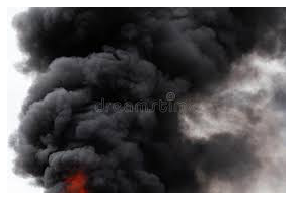

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'Label_{x.name}'
# get_y_fn = lambda x: path_lbl/f'Label_{x.stem}{x.suffix}'

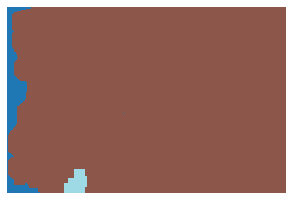

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([183, 275]), tensor([[[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]]]))

In [11]:
codes = ['smoke', 'flame', 'person', 'Void']

# Dataset

In [12]:
# size = src_size//2
# bs = 4
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3602MB of GPU RAM free


In [13]:
# defaults.device = torch.device('cpu')
# bs = 8
# size = src_size//2

In [14]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137)
y: SegmentationLabelList
ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137)
Path: data/fireandsmoke/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137)
y: SegmentationLabelList
ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137)
Path: data/fireandsmoke/images;

Test: None


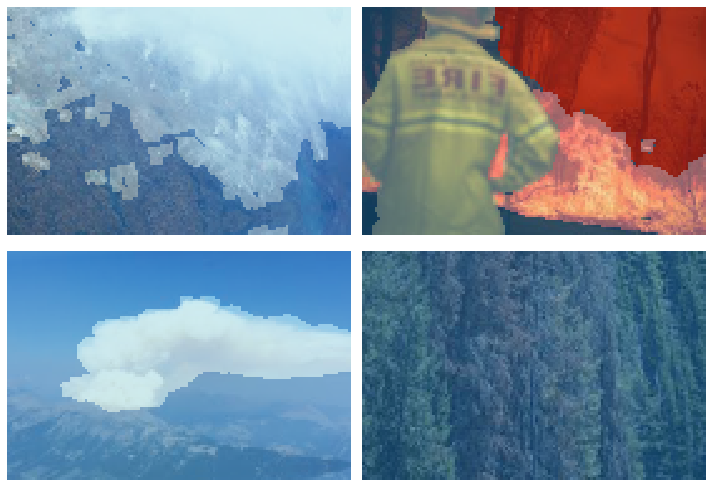

In [17]:
data.show_batch(4, figsize=(10,7))
print(data)

# Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_smoke
# metrics=accuracy

In [20]:
# wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics) # , wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


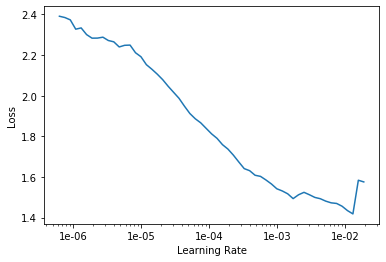

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr =1e-2
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,4.057215,1.817364,0.535953,00:04
1,2.872329,1.079083,0.505155,00:01
2,2.243778,1.023308,0.514537,00:01
3,2.639947,1.241909,0.438540,00:01
4,2.226651,0.910847,0.657485,00:01
5,1.933778,0.916751,0.626519,00:01
6,1.705615,1.003784,0.590681,00:01
7,1.524291,0.826478,0.685964,00:01
8,1.368591,0.804743,0.699297,00:01
9,1.249974,0.802541,0.705419,00:01


In [24]:
learn.save('stage-1')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137)
y: SegmentationLabelList
ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137)
Path: data/fireandsmoke/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137),Image (3, 91, 137)
y: SegmentationLabelList
ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137),ImageSegment (1, 91, 137)
Path: data/fireandsmoke/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPo

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


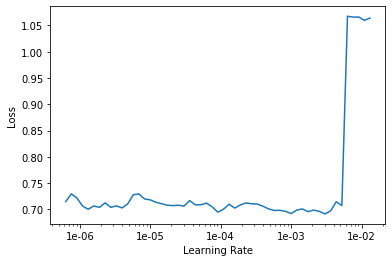

In [26]:
lr_find(learn)
learn.recorder.plot()

At the learning rate 1e-4, the loss is still going down, so we can pick the learning rate 1e-3.

In [27]:
lrs=slice(2e-3)
learn.fit_one_cycle(12,lrs)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.714349,0.803314,0.700025,00:01
1,0.702843,0.805835,0.701059,00:01
2,0.676078,0.801736,0.706432,00:01
3,0.669162,0.791711,0.688449,00:01
4,0.670778,0.712937,0.738375,00:01
5,0.670718,0.735336,0.708423,00:01
6,0.659870,0.665018,0.766590,00:01
7,0.648980,0.646568,0.772804,00:01
8,0.641529,0.676148,0.766803,00:01
9,0.624840,0.642130,0.771317,00:01


* $\Downarrow$ fire anealing is used for this learning rate

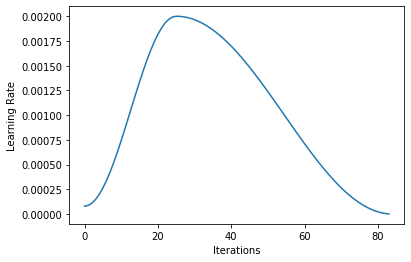

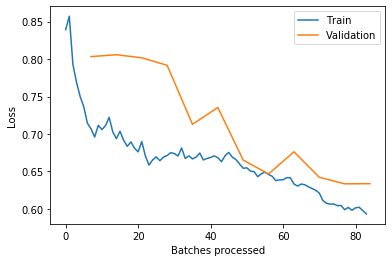

In [28]:
learn.recorder.plot_lr()
learn.recorder.plot_losses()

In [29]:
learn.save('stage-2')

# Go Bigger

In [30]:
# in case of the running out of memory
bs=4
size = src_size

In [31]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

# !!! New CUDA
**Here we use the `mixed precision training`: instead of using single precision floating point numbers, we do all the computations in our model with half precision floating point numbers (16bites <-- 32bites) so that we can use less GPU ram**, same purpose as the above `bs=4`.
* New CUDA is needed to do that

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()

In [34]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


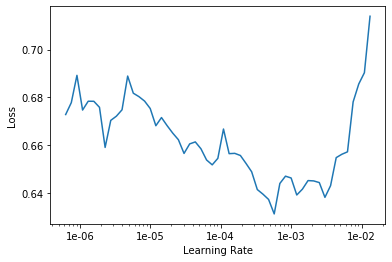

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr = 5e-4

In [37]:
learn.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,0.602794,0.738487,0.800791,00:06
1,0.629520,0.616236,0.852939,00:04
2,0.620786,0.654454,0.850265,00:04
3,0.598392,0.692809,0.845369,00:04
4,0.593094,0.699576,0.849950,00:04
5,0.584290,0.702691,0.848667,00:04
6,0.572896,0.686817,0.847436,00:04
7,0.563572,0.687095,0.848003,00:04
8,0.554360,0.684742,0.851338,00:04
9,0.545759,0.678380,0.848767,00:03


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(1e-6,lr)
learn.fit_one_cycle(10,lrs,wd=1e-3)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.546819,0.688764,0.845448,00:04
1,0.529827,0.707889,0.847647,00:04
2,0.518844,0.688835,0.850558,00:04
3,0.517972,0.718257,0.852792,00:04
4,0.516526,0.728486,0.858085,00:04
5,0.504852,0.776046,0.860347,00:04
6,0.487318,0.795663,0.854942,00:04
7,0.491556,0.787898,0.857394,00:04
8,0.483468,0.776137,0.856629,00:04
9,0.478835,0.774822,0.857416,00:04


In [42]:
learn.save('stage-2-big')

In [43]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275),Image (3, 183, 275)
y: SegmentationLabelList
ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275),ImageSegment (1, 183, 275)
Path: data/fireandsmoke/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

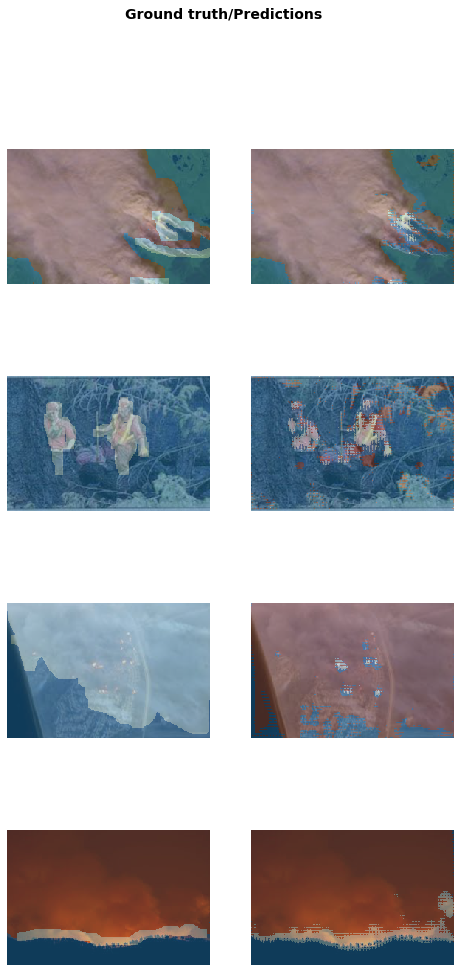

In [48]:
learn.show_results(rows=4)

# Turn into Product

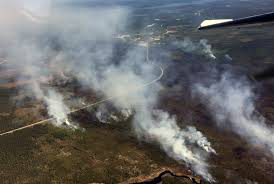

In [83]:
img0 = open_image(path/'pic1.jfif')
img0

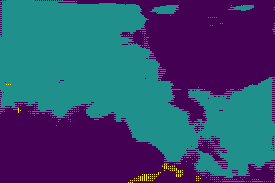

In [84]:
prediction0 = learn.predict(img0)
prediction0[0]

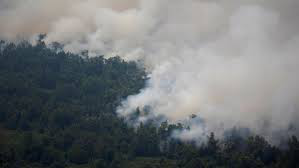

In [85]:
img1 = open_image('data/firedetection/w.jfif') # fire
img1

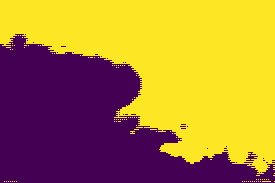

In [86]:
prediction1 = learn.predict(img1)
prediction1[0]

In [87]:
from moviepy.editor import VideoFileClip
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_shape = image.shape[:2]
#     print(image_shape)
    image = cv2.resize(image,(256,256))
    first_img = np.expand_dims(image, 0)/255.0
#     result = image_pipeline(image)
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = first_img[0][:,:,0]*0.7 + 0.3*first_seg[0, :, :, 0]
    result = np.array(np.clip(first_img[0]*255,0,255),dtype=np.float)
#     print(image_shape[:2],result.shape,type(result[0][0][0]))
    result = cv2.resize(result,image_shape[::-1])
#     result = result[...,::-1]
    
    return result

In [128]:
# filename=path/'video1.mp4'
# clip = VideoFileClip(filename)
# white_clip = clip.fl_image(process_image)
# %time white_clip.write_videofile(filename.split('.')[0]+'_detection.mp4', audio=False)